In [2]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('B://workspace/tensorflow')

import numpy as np

from torch.utils.data import DataLoader, random_split

from src.dataset.Argo import Argo3DTemperatureDataset
from src.config.params import Areas
from src.utils.log import Log

width = 20
height = 20

area = Areas[2]

dataset = Argo3DTemperatureDataset(lon=np.array(area['lon']) + 180, lat=np.array(area['lat']) + 80, depth=[0, 58])

# 按照 7：2：1 的比例划分数据集
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.2, 0.1])

print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

input, output = next(iter(train_loader))
val_input, val_output = next(iter(val_loader))

# 将三维数据重塑为二维
input_shape = input.shape
input = input.reshape(-1, input.shape[-1])  # 将(n,m,k)转换为(n*m,k)
output = output.reshape(-1, output.shape[-1])

val_input = val_input.reshape(-1, val_input.shape[-1])
val_output = val_output.reshape(-1, val_output.shape[-1])

print(f"训练数据形状: input={input.shape}, output={output.shape}")
print(f"验证数据形状: val_input={val_input.shape}, val_output={val_output.shape}")


170 48 24
训练数据形状: input=torch.Size([68000, 3]), output=torch.Size([68000, 58])
验证数据形状: val_input=torch.Size([19200, 3]), val_output=torch.Size([19200, 58])


temp: (360, 160, 58)


<GeoAxes: >

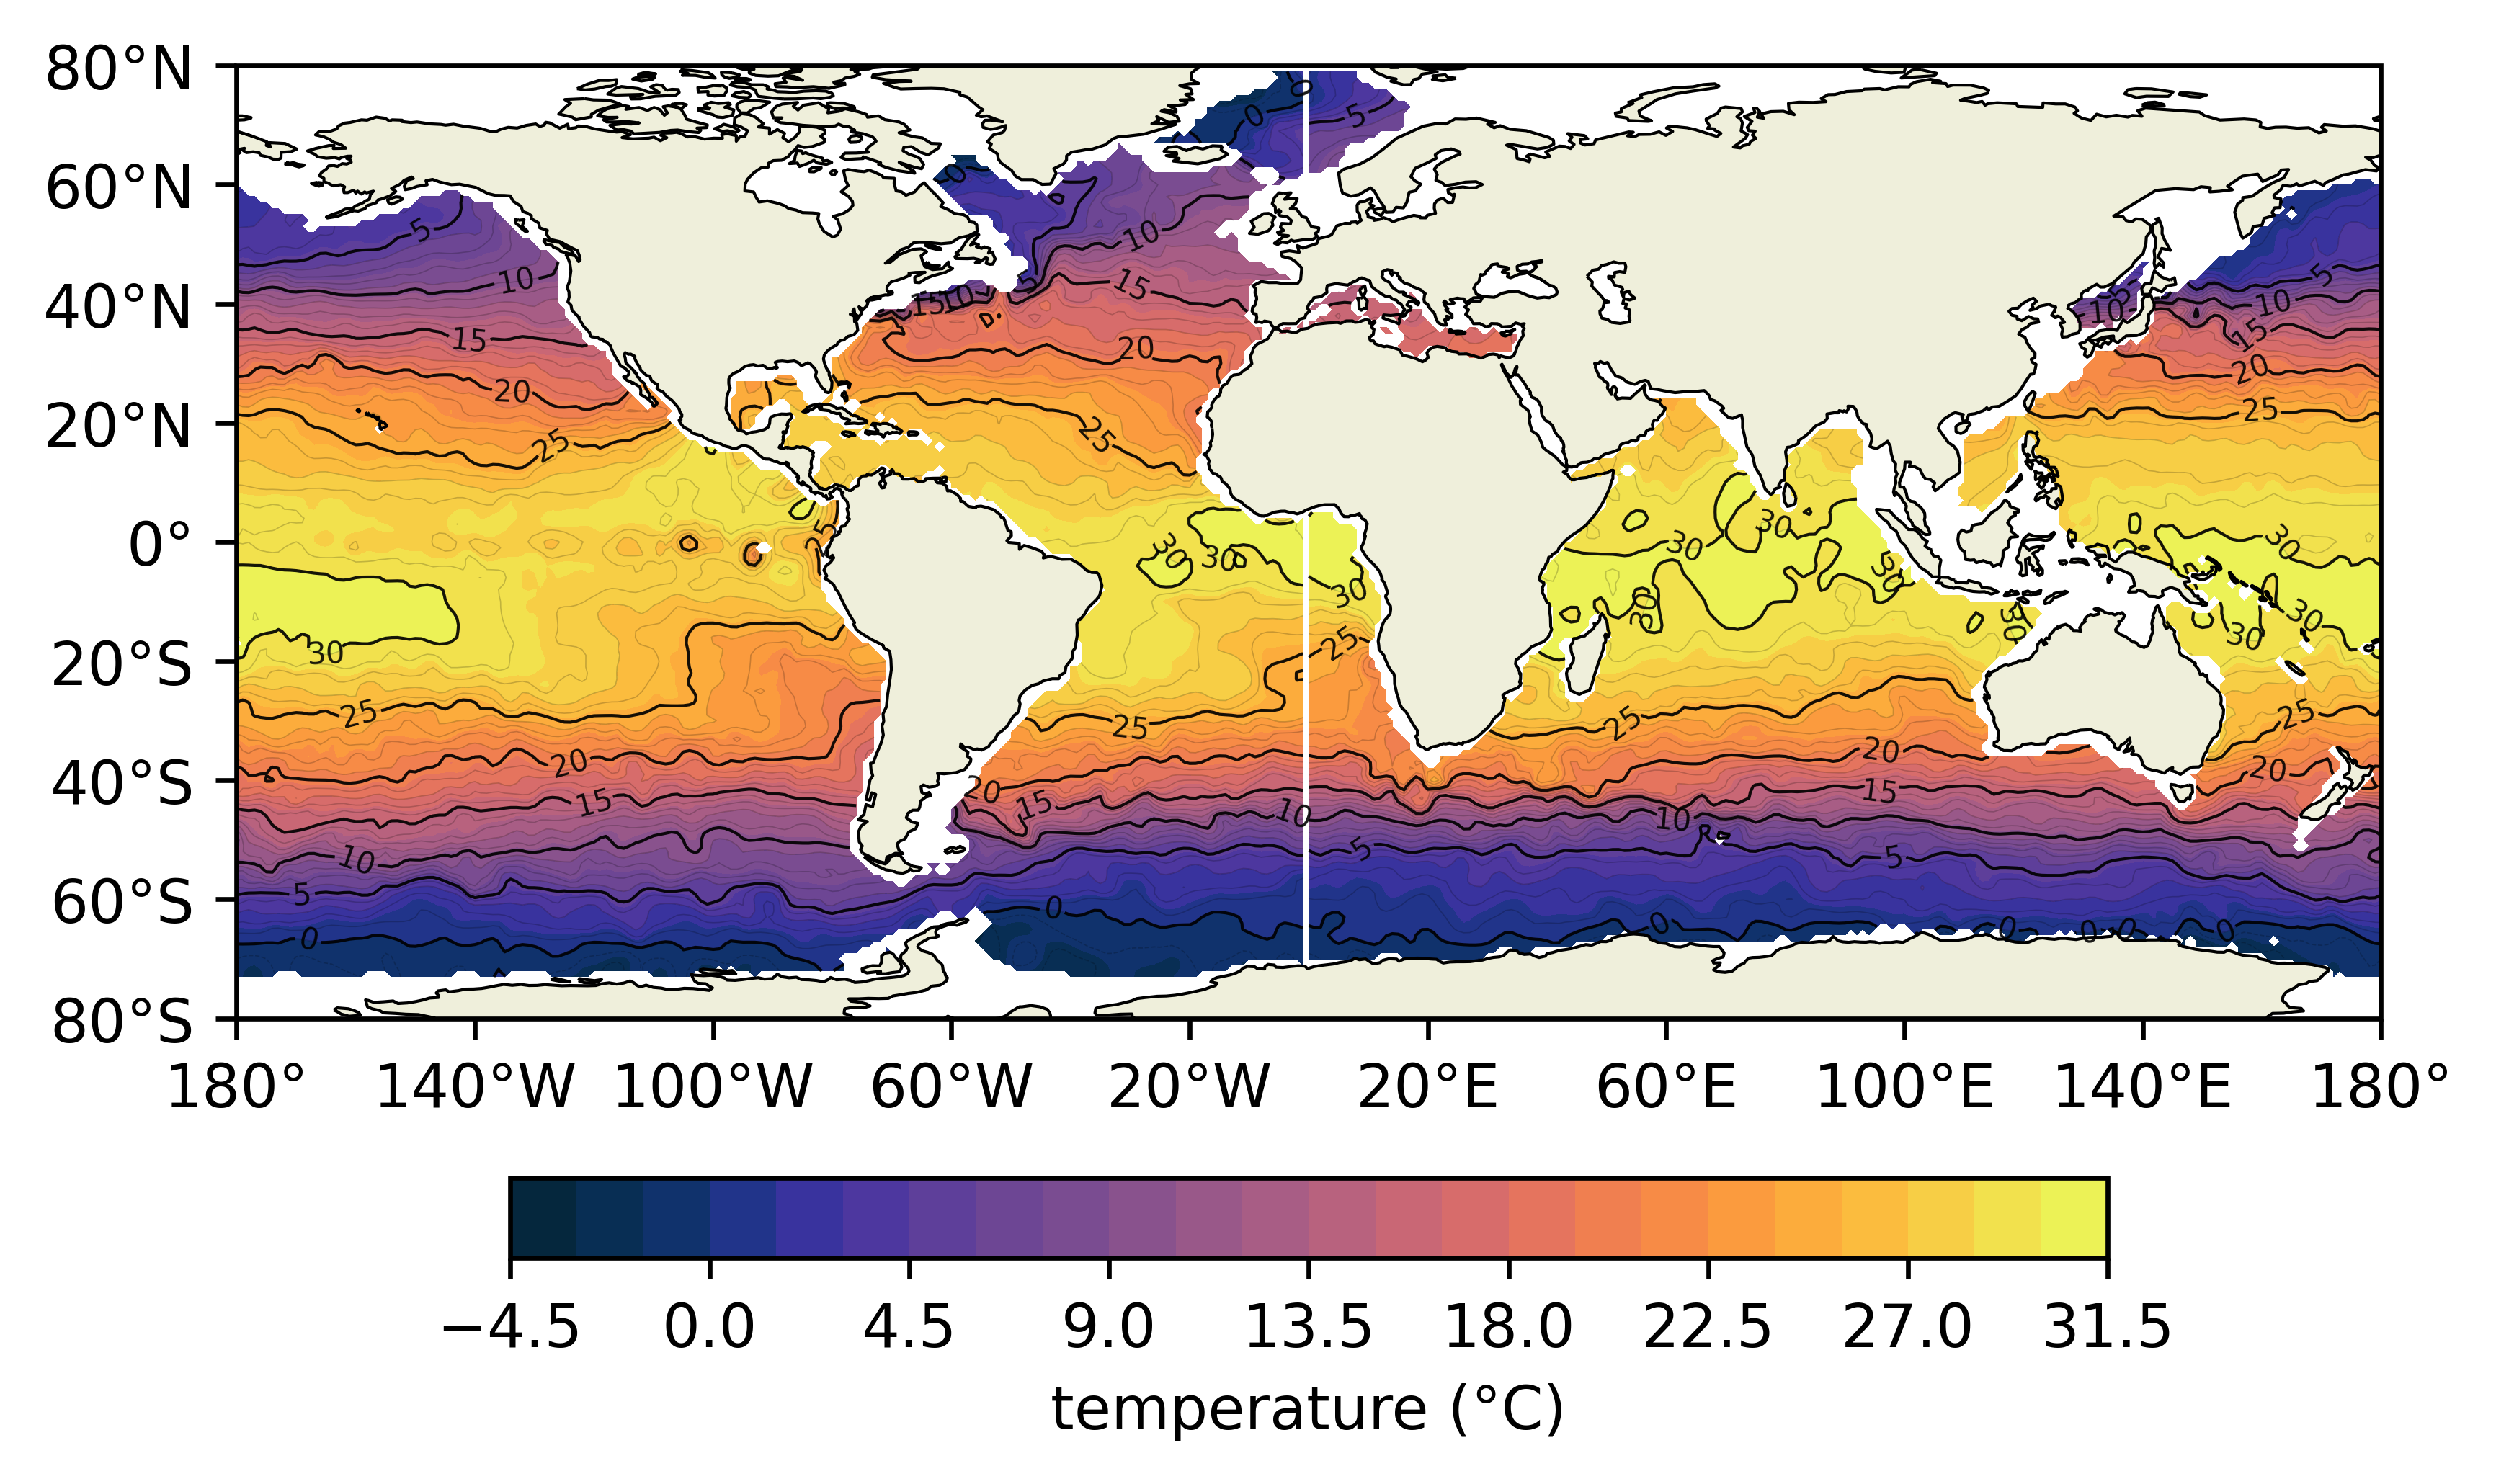

In [10]:
# argo 原始数据的季节性验证
from src.plot.sst import plot_sst_l


loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

input, output = next(iter(loader))

last_month = dataset.current_month()

temp = last_month['temp']
sst = temp[:, :, 0]

Log.d(f"temp: {temp.shape}")

# 绘制海表温度图
plot_sst_l(sst, [-180, 180], [-80, 80])


In [81]:

# 选取站点检验剖面时间序列可靠性
from src.plot.base import create_shared_axes

depth = np.array([
    0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
    110, 120, 130, 140, 150, 160, 170, 180, 200,
    220, 240, 260, 280, 300, 320, 340, 360, 380, 400,
    420, 440, 460, 500, 550, 600, 650, 700, 750, 800,
    850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250,
    1300, 1400, 1500, 1600, 1700, 1800, 1900, 1975
])

stations = [
    [142, 0],
    [-15, 0],
    [92, 0]
]

names = ['a) ', 'b) ', 'c) ']
positions = ["0°N, 142°E", "0°N, 15°W", "0°N, 92°E"]

axes = create_shared_axes(3, 1, 'x')

for i, station in enumerate(stations):
    lon, lat = station
    lon = lon + 180
    lat = lat + 80
    
    dataset = Argo3DTemperatureDataset(lon=np.array([lon, lon+1]), lat=np.array([lat, lat+1]), depth=[0, 58])
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    
    input, output = next(iter(loader))

    profile = output[:, 0, :35].numpy().T
    
    ax = axes[i]
    # 将 depth 设置为 Y 轴刻度
    ax.set_yticks(np.arange(0, len(depth[:35]), 5))
    # 设置对应的深度值标签
    ax.set_yticklabels(depth[:35][::5])
    
    # 设置 X 轴刻度，2004年1月到2024年3月
    ax.set_xticks(np.arange(0, 242, 24))
    # 设置小刻度
    ax.set_xticks(np.arange(0, 242, 12), minor=True)
    ax.set_xticklabels(np.arange(2004, 2025, 2))

    ax.contourf(profile)
    ax.contour(profile, colors='black', alpha=0.5, linewidths=0.2, linestyles='--', levels=30)
    contour_lines = ax.contour(profile, colors='black', linewidths=0.5)
    # 修改文本位置到左上角，使用相对坐标
    ax.text(0.02, 0.12, f"{names[i]} {positions[i]}", 
            fontsize=8, 
            color='orange',
            transform=ax.transAxes,  # 使用相对坐标系统
            verticalalignment='bottom'
    )
    labels = ax.clabel(contour_lines, inline=True, fontsize=5, fmt='%d', manual=False)

    # 为每个标签添加白色背景
    for label in labels:
        label.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))
        
    ax.invert_yaxis()
    

In [10]:
# 训练模型
from src.models.RDF import RDFNetwork

model = RDFNetwork()

model = model(input, output)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   38.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  5.9min


In [11]:
# ------------------------------------ 预测海温数据 ------------------------
print(dataset.current)

score = model.score(val_input, val_output)
print(f"Model R^2 score: {score}")


201


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    6.2s


Model R^2 score: 0.999999999660687


shape:  torch.Size([1, 400, 3])


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s


1000dbr 以上的平均RMSE： 0.36280282858329377
1000dbr 以上的平均RMSE： 0.10346728719909472
min: 3.455199956893921, max: 26.2406005859375


[<Axes3D: >, <Axes3D: >]

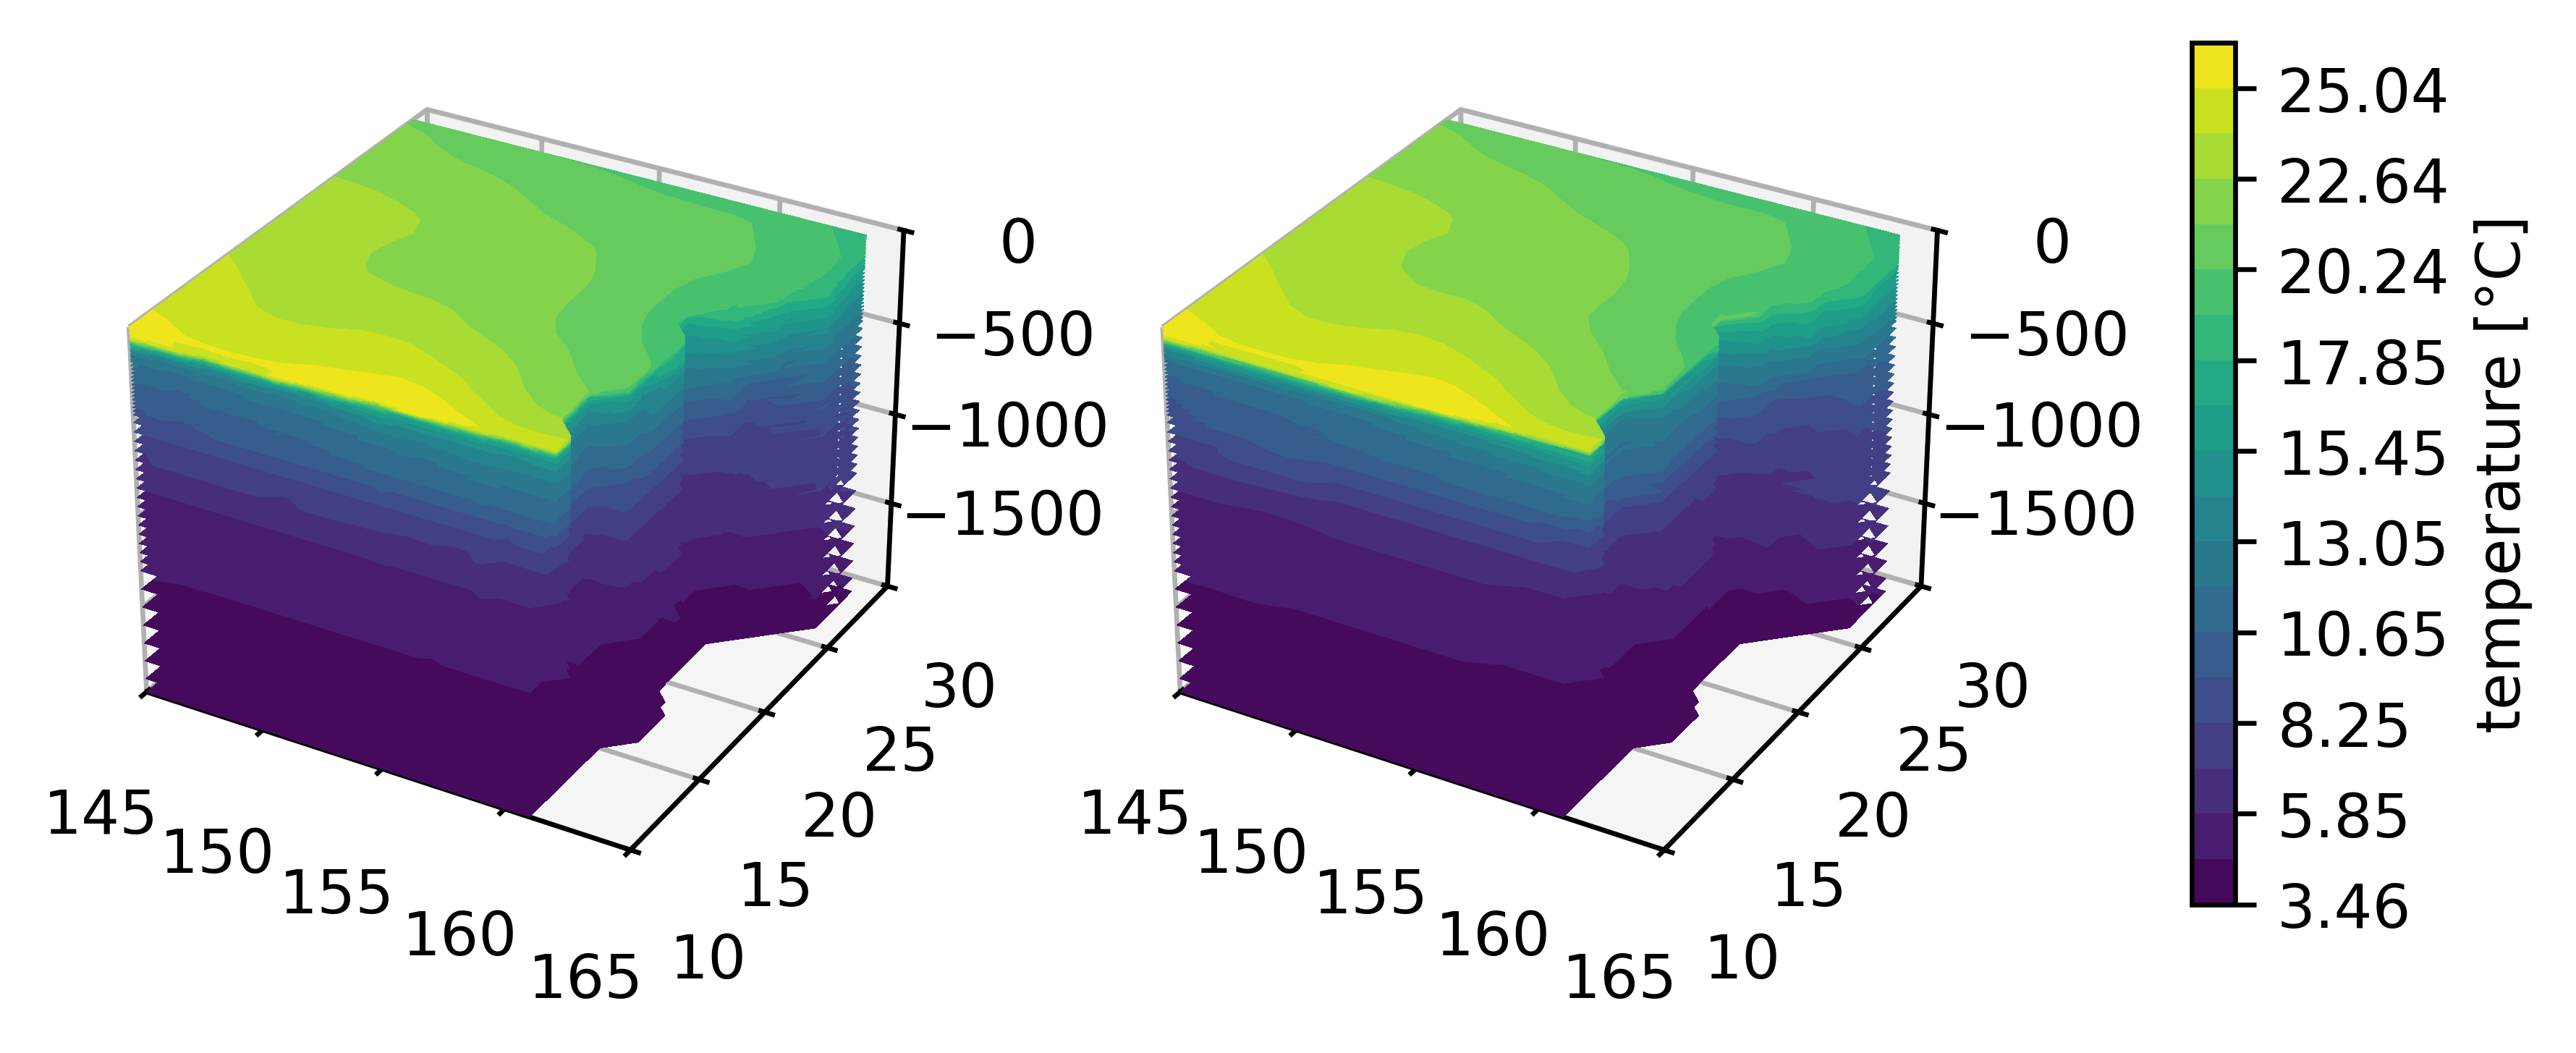

In [24]:
# 预测海温数据
import numpy as np
from src.plot.profile import plot_3d_temperature_comparison

all_test_input, all_test_output = next(iter(test_loader))

print("shape: ", all_test_input.shape)

test_input = all_test_input[0]
test_output = all_test_output[0]

test_input = test_input.reshape(-1, test_input.shape[-1])
test_output = test_output.reshape(-1, test_output.shape[-1])

pres_result = model.predict(test_input)

pres_result[pres_result > 50] = np.nan
pres_profile = pres_result[:, :].reshape(width, height, 58)

rmses = []

# 计算每层的 RMSE
for i in range(58):
    pred_temp = pres_profile[:, :, i]
    true_temp = test_output[:, i].reshape(width, height).numpy()
    true_temp[true_temp > 50] = np.nan
    
    abs_error = np.abs(pred_temp - true_temp)
    mse = np.nanmean((pred_temp - true_temp) ** 2)
    rmse = np.sqrt(mse)
    rmses.append(rmse)
    
Log.w(f"1000dbr 以上的平均RMSE：", np.nanmean(rmses[:45]))
Log.w(f"1000dbr 以上的平均RMSE：", np.nanmean(rmses[45:]))
    
depth = np.array([
    0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
    110, 120, 130, 140, 150, 160, 170, 180, 200,
    220, 240, 260, 280, 300, 320, 340, 360, 380, 400,
    420, 440, 460, 500, 550, 600, 650, 700, 750, 800,
    850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250,
    1300, 1400, 1500, 1600, 1700, 1800, 1900, 1975
])

plot_3d_temperature_comparison(
        pres_profile, test_output.reshape(20, 20, 58),
        area['lon'], area['lat'], depth
        )

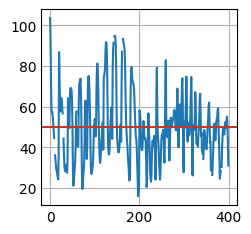

In [10]:
from matplotlib import cm # type: ignore
import matplotlib.pyplot as plt # type: ignore
from matplotlib.ticker import MultipleLocator # type: ignore

# 绘制混合层深度分布图
Log.i(mld.shape)

mld = mld.reshape(360, 160)[160:180, 60:80].flatten()
mean_mld = np.mean(mld)

plt.plot(mld)
plt.axhline(mean_mld, color='#c0392b')

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 20

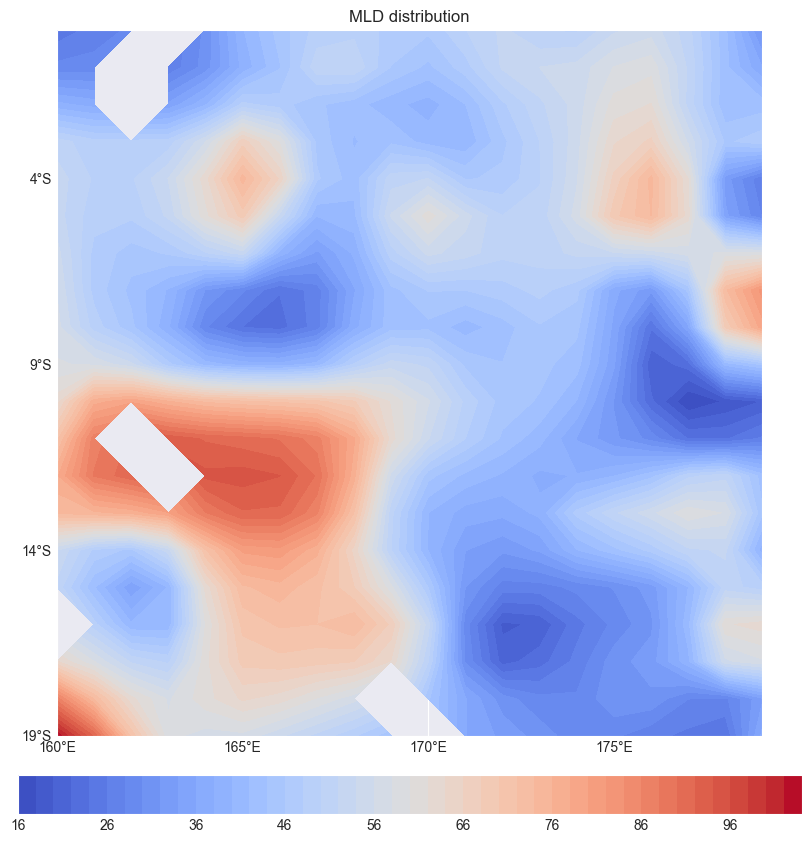

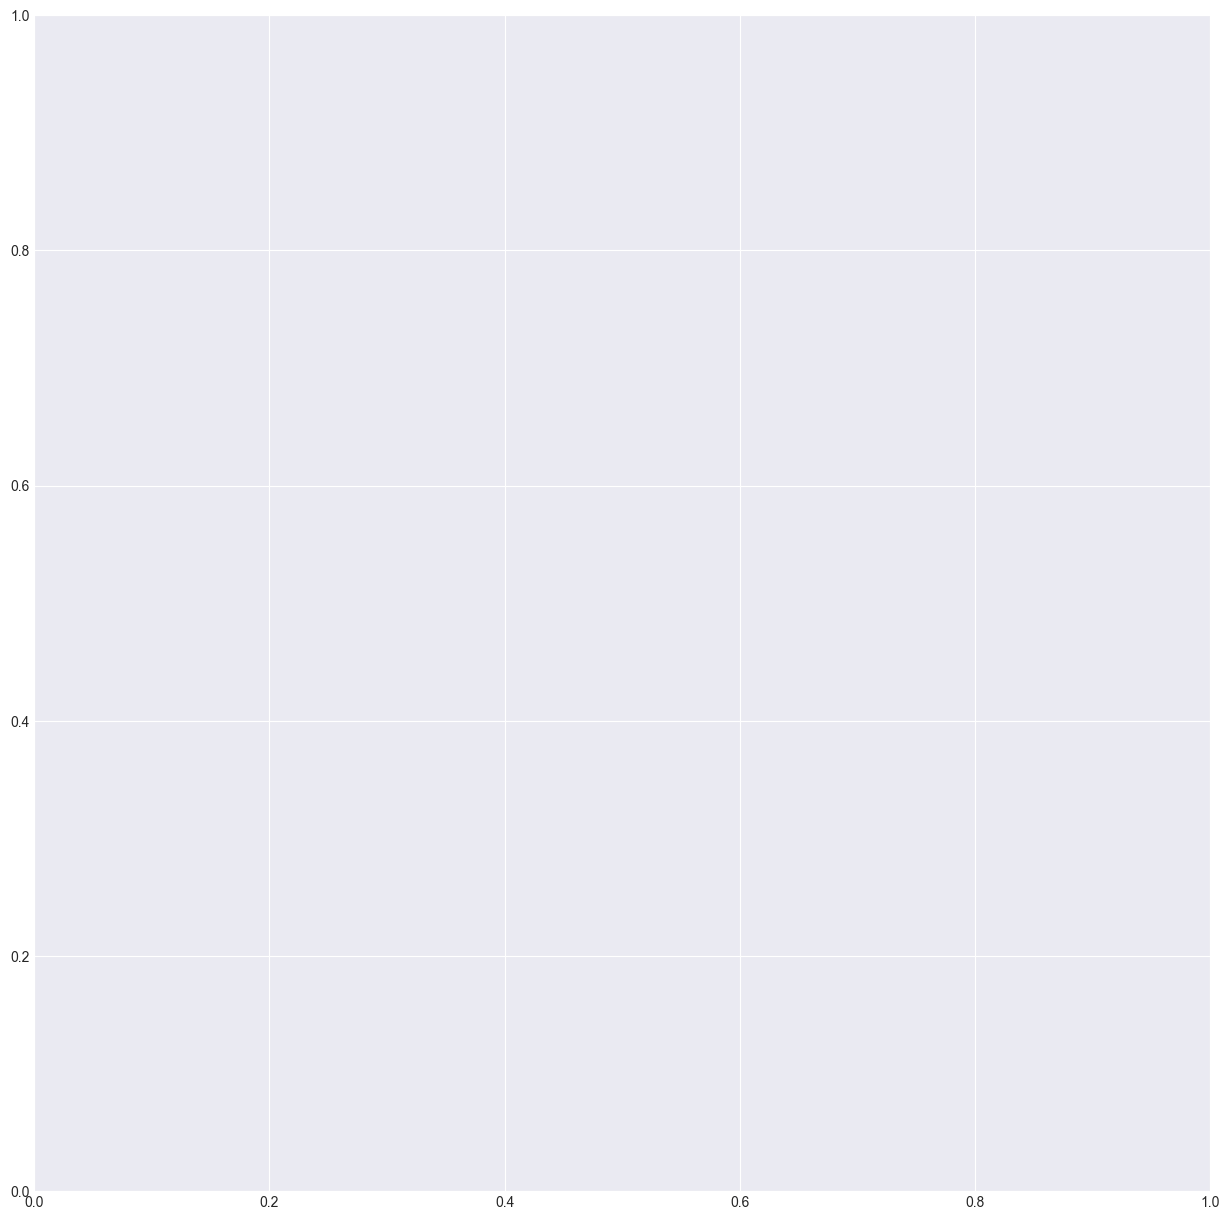

In [15]:
mld_dist = mld.reshape(20, 20)

import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

figure = plt.figure(figsize=(10, 8))
ax = figure.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_title("MLD distribution")

ax.set_xticks(np.arange(160, 181, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-19, 1, 5), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

lon = np.arange(160, 180, 1)
lat = np.arange(-19, 1, 1)
X, Y = np.meshgrid(lon, lat)

contour = ax.contourf(lon, lat, mld_dist, cmap='coolwarm', levels=50, transform=ccrs.PlateCarree())

cbar = figure.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, fraction=0.05)


figure, ax = plt.subplots(figsize=(12, 12))

corr = np.corrcoef(max_abs_error, mld_dist)[20:, 20:]

sns.heatmap(corr, square=True, annot=False, ax=ax)

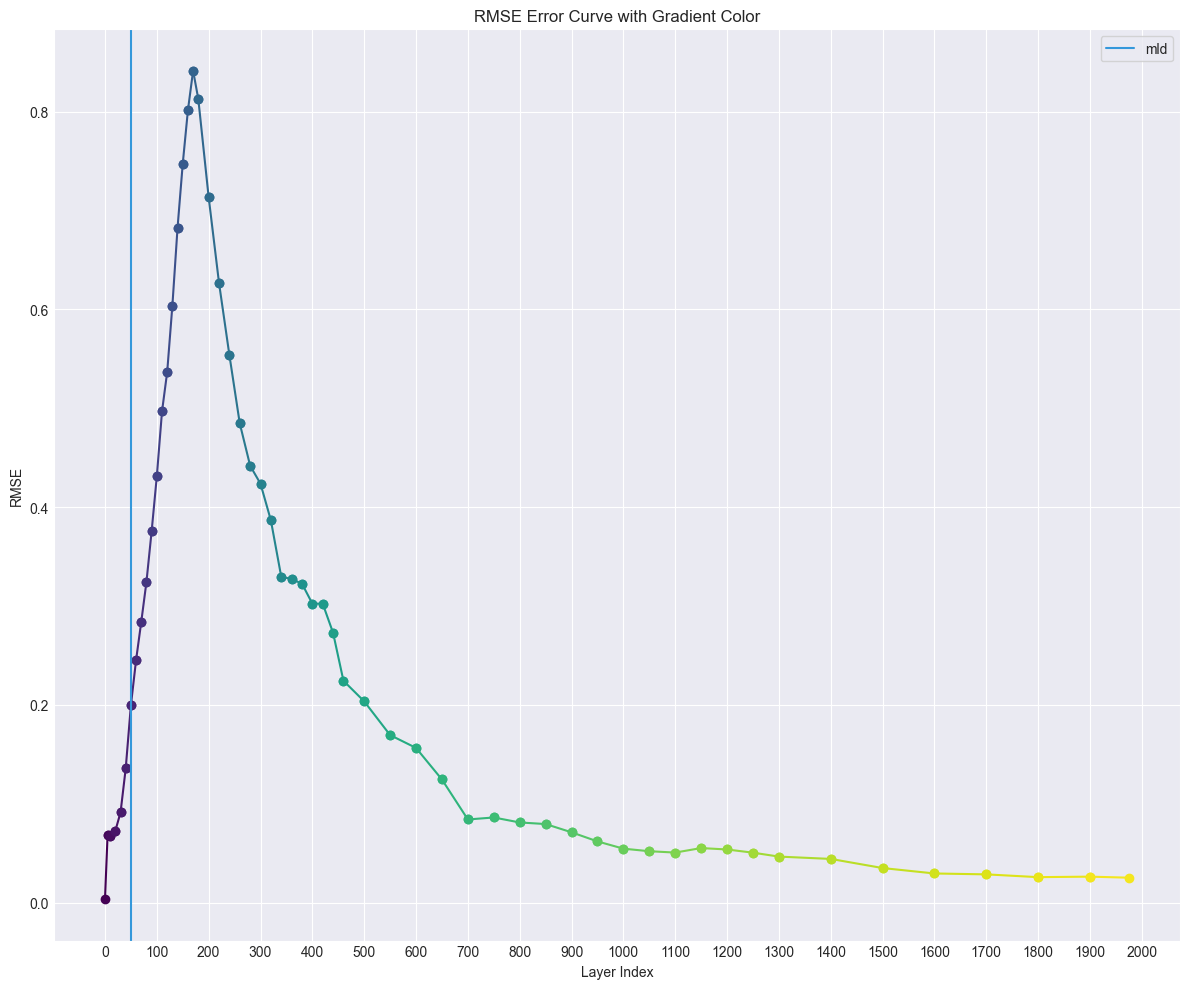

In [16]:
# 绘制 rmse 的分布图

deep_map = [
    0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
    110, 120, 130, 140, 150, 160, 170, 180, 200,
    220, 240, 260, 280, 300, 320, 340, 360, 380, 400,
    420, 440, 460, 500, 550, 600, 650, 700, 750, 800,
    850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250,
    1300, 1400, 1500, 1600, 1700, 1800, 1900, 1975
]

x = deep_map
y = rmse_values

colors = cm.viridis(np.linspace(0, 1, len(rmse_values)))

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 10))

# Plot the RMSE values with gradient color
for i in range(len(rmse_values) - 1):
    ax1.plot(x[i:i + 2], rmse_values[i:i + 2], marker='o', linestyle='-', color=colors[i])

ax1.set_xlabel('Layer Index')
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE Error Curve with Gradient Color')
ax1.grid(True)

# Set x-axis major ticks to have an interval of 5
ax1.xaxis.set_major_locator(MultipleLocator(100))

# Show the plot
plt.tight_layout()
plt.axvline(mean_mld, color='#3498db', label='mld')
plt.legend()